In [1]:
import numpy as np
import tensorflow as tf

In [2]:
class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate=0.1, epochs=10, batch_size=10):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.weights = tf.Variable(tf.random.normal([num_visible, num_hidden], stddev=0.1), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([num_visible]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden]), dtype=tf.float32)
    
    def _sigmoid(self, x):
        return 1 / (1 + tf.exp(-x))
    
    def _sample_hidden(self, visible_probabilities):
        hidden_probabilities = self._sigmoid(tf.matmul(visible_probabilities, self.weights) + self.hidden_bias)
        return hidden_probabilities, tf.nn.relu(tf.sign(hidden_probabilities - tf.random.uniform(tf.shape(hidden_probabilities))))
    
    def _sample_visible(self, hidden_probabilities):
        visible_probabilities = self._sigmoid(tf.matmul(hidden_probabilities, tf.transpose(self.weights)) + self.visible_bias)
        return visible_probabilities, tf.nn.relu(tf.sign(visible_probabilities - tf.random.uniform(tf.shape(visible_probabilities))))
    
    def train(self, data):
        for epoch in range(self.epochs):
            reconstruction_error = 0.0
            for i in range(0, len(data), self.batch_size):
                batch = data[i:i+self.batch_size]
                visible_probabilities_0 = batch
                hidden_probabilities_0, hidden_samples_0 = self._sample_hidden(visible_probabilities_0)
                visible_probabilities_k, visible_samples_k = self._sample_visible(hidden_samples_0)
                hidden_probabilities_k, _ = self._sample_hidden(visible_probabilities_k)
                
                delta_weights = tf.matmul(tf.transpose(visible_probabilities_0), hidden_probabilities_0) - tf.matmul(tf.transpose(visible_probabilities_k), hidden_probabilities_k)
                self.weights.assign_add(self.learning_rate * delta_weights / len(data))
                self.visible_bias.assign_add(self.learning_rate * tf.reduce_mean(visible_probabilities_0 - visible_probabilities_k, axis=0))
                self.hidden_bias.assign_add(self.learning_rate * tf.reduce_mean(hidden_probabilities_0 - hidden_probabilities_k, axis=0))
                
                reconstruction_error += tf.reduce_mean(tf.square(visible_probabilities_0 - visible_probabilities_k))
                
            print("Epoch {}, Reconstruction Error: {}".format(epoch+1, reconstruction_error))

In [3]:
class DeepBeliefNetwork:
    def __init__(self, rbm_layers, rbm_learning_rate=0.1, rbm_epochs=10, rbm_batch_size=10):
        self.rbm_layers = rbm_layers
        self.rbm_learning_rate = rbm_learning_rate
        self.rbm_epochs = rbm_epochs
        self.rbm_batch_size = rbm_batch_size
        self.rbms = []
    
    def add_rbm_layer(self, num_visible, num_hidden):
        rbm = RBM(num_visible=num_visible, num_hidden=num_hidden,
                  learning_rate=self.rbm_learning_rate,
                  epochs=self.rbm_epochs, batch_size=self.rbm_batch_size)
        self.rbms.append(rbm)
    
    def train(self, data):
        visible_data = data
        for rbm in self.rbms:
            print(f"Training RBM: {rbm.num_visible} -> {rbm.num_hidden}")
            rbm.train(visible_data)
            hidden_features = rbm._sample_hidden(visible_data)[0]
            visible_data = hidden_features.numpy()
    
    def transform(self, data):
        visible_data = data
        for rbm in self.rbms:
            hidden_features = rbm._sample_hidden(visible_data)[0]
            visible_data = hidden_features.numpy()
        return visible_data

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

11490434/11490434 [==============================] - 3s 0us/step


In [9]:
train_images = train_images.reshape(train_images.shape[0], -1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], -1).astype('float32')

In [6]:
dbn = DeepBeliefNetwork(rbm_layers=[(784, 500), (500, 200)], rbm_epochs=10, rbm_batch_size=100)

for num_visible, num_hidden in dbn.rbm_layers:
    dbn.add_rbm_layer(num_visible, num_hidden)
    
dbn.train(train_images)

Training RBM: 784 -> 500
Epoch 1, Reconstruction Error: 42.36492919921875
Epoch 2, Reconstruction Error: 35.15315246582031
Epoch 3, Reconstruction Error: 34.13801193237305
Epoch 4, Reconstruction Error: 33.16805648803711
Epoch 5, Reconstruction Error: 32.21097946166992
Epoch 6, Reconstruction Error: 31.25092124938965
Epoch 7, Reconstruction Error: 30.318477630615234
Epoch 8, Reconstruction Error: 29.405179977416992
Epoch 9, Reconstruction Error: 28.53005599975586
Epoch 10, Reconstruction Error: 27.702219009399414
Training RBM: 500 -> 200
Epoch 1, Reconstruction Error: 34.395240783691406
Epoch 2, Reconstruction Error: 33.00694274902344
Epoch 3, Reconstruction Error: 32.170841217041016
Epoch 4, Reconstruction Error: 31.48993682861328
Epoch 5, Reconstruction Error: 30.940654754638672
Epoch 6, Reconstruction Error: 30.461877822875977
Epoch 7, Reconstruction Error: 30.034025192260742
Epoch 8, Reconstruction Error: 29.6236629486084
Epoch 9, Reconstruction Error: 29.23529052734375
Epoch 10, R

In [1]:
import matplotlib.pyplot as plt

def plot_images(original_images, reconstructed_images, num_images=6):
    plt.figure(figsize=(25, 9))
    for i in range(num_images):
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].numpy().reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

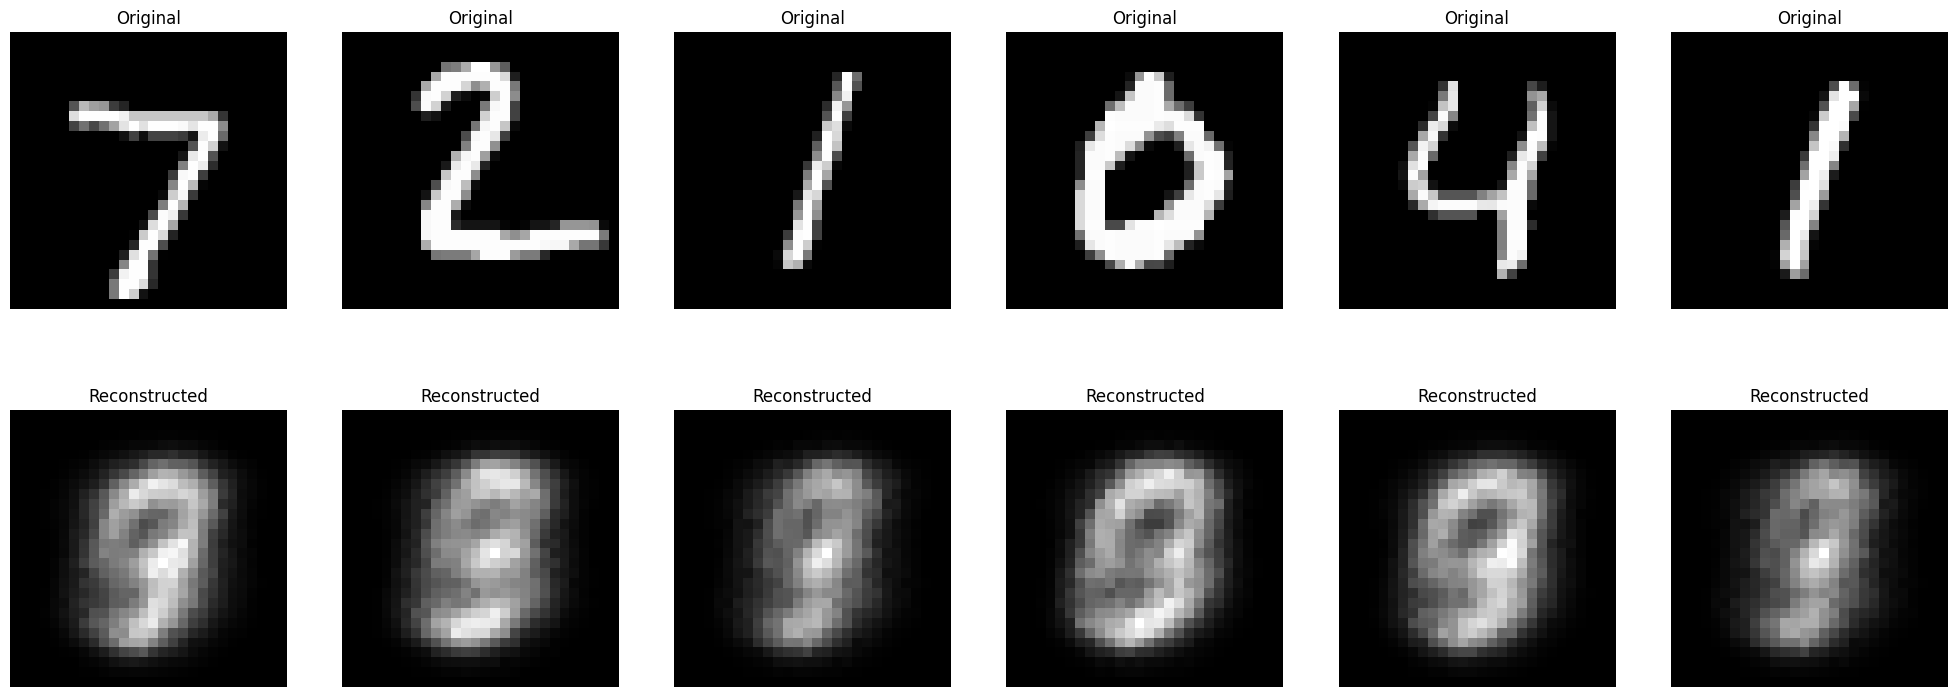

In [8]:
transformed_test_images = tf.convert_to_tensor(test_images)
for rbm in dbn.rbms:
    transformed_test_images = rbm._sample_hidden(transformed_test_images)[0]

reconstructed_test_images = transformed_test_images
for rbm in reversed(dbn.rbms):
    reconstructed_test_images = rbm._sample_visible(reconstructed_test_images)[0]

plot_images(test_images, reconstructed_test_images)